## Vehicle Price Prediction

Predicting the best equation for selling price for a car using the vehicle dataset

### Data Cleaning

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import missingno as msno
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
from numpy import std
from matplotlib import pyplot as plt

In [2]:
# Setup base paths
data_path = "./data/"

In [3]:
# Read the dataset
car_df = pd.read_csv(data_path + "vehicle_data.csv")
car_df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [4]:
# Check columns and their types
car_df.columns, car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


(Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
        'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
       dtype='object'), None)

In [5]:
# Check to see if any column has a single value
# Columns that have a single value for all rows do not contain any information for modeling
# Depending on the choice of data preparation and modeling algorithms, variables with a single value can also cause errors or unexpected results
# Variables or columns that have a single value should probably be removed from your dataset
car_df.nunique()

Car_Name          98
Year              16
Selling_Price    156
Present_Price    147
Kms_Driven       206
Fuel_Type          3
Seller_Type        2
Transmission       2
Owner              3
dtype: int64

In [6]:
# Summarize the percentage of unique values for each column
for i in range(car_df.shape[1]):
    num = car_df.iloc[:, i].nunique()
    percentage = round(float(num) / car_df.shape[0] * 100, 2)
    if percentage < 1:
        print("Column: {}, Total unique values: {}, Percentage unique values: {}".format(car_df.columns[i], num, percentage))

Column: Seller_Type, Total unique values: 2, Percentage unique values: 0.66
Column: Transmission, Total unique values: 2, Percentage unique values: 0.66


#### **Inference**

There's no column with single unique values.
The percentage of unique values for the columns - _Seller_Type, Transmission_ is less than 1%. Since these could be columns with ordinal/categorical values, they cannot be removed.

In [7]:
# Check to see if any column has low variance
# Columns that have low variance do not contain any information for modeling
data = car_df[list(car_df.select_dtypes(exclude=['object']).columns)].values
X_var = data[:, :-1]
y_var = data[:, -1]
print(X_var.shape, y_var.shape)
# Define the transform
transform = VarianceThreshold(threshold=0)
# Transform the input data
X_sel = transform.fit_transform(X_var)
print(X_sel.shape)

(301, 4) (301,)
(301, 4)


In [8]:
# Check to see duplicate rows
# Rows that have identical data are probably useless, if not dangerously misleading during model evaluation
check_duplicates_df = car_df.applymap(str)
dups = check_duplicates_df.duplicated(subset=list(check_duplicates_df.columns))
# Report if there are any duplicates
print(dups.all())
# List all duplicate rows
check_duplicates_df[dups]

False


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
93,fortuner,2015,23.0,30.61,40000,Diesel,Dealer,Automatic,0


#### **Inference**

- None of the columns in the dataset have variance less than threshold=0.
- There are no duplicates in the dataset.

### Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Selling_Price'}>],
       [<AxesSubplot:title={'center':'Present_Price'}>,
        <AxesSubplot:title={'center':'Kms_Driven'}>]], dtype=object)

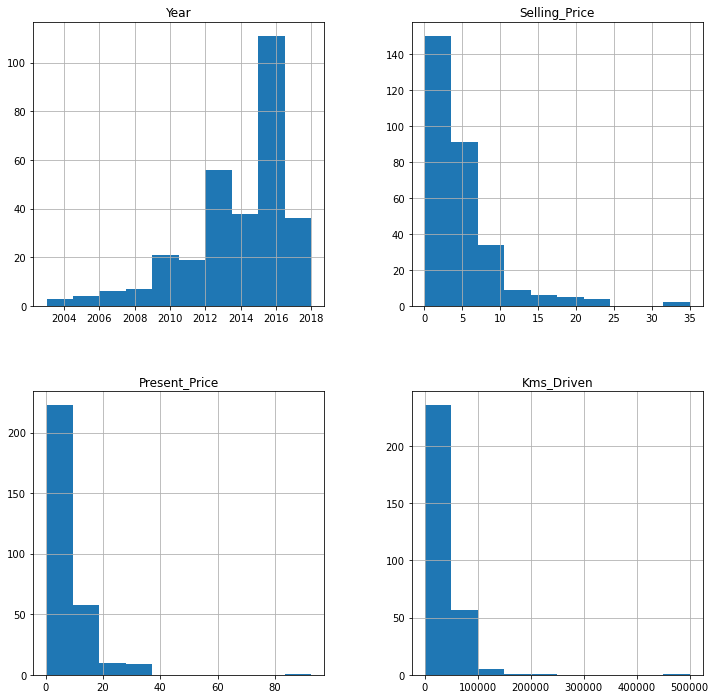

In [9]:
# Check Distributions 
car_df_num = car_df[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']]
car_df_cat = car_df[['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']]

# For checking distribution of numeric columns - use histogram
car_df_num.hist(figsize=(12,12))

#### **Inference**
From the histograms:

* Year has fairly normal distribution.
* Selling_Price, Present_Price, Kms_Driven has right skewed distributions.

We can consider normalizing Selling_Price, Present_Price, Kms_Driven before scaling the dataset.

In [10]:
# Check unique values in Car_Name, Fuel_Type, Seller_Type, Transmission
car_df.Car_Name.unique(), car_df.Fuel_Type.unique(), car_df.Seller_Type.unique(), car_df.Transmission.unique()

(array(['ritz', 'sx4', 'ciaz', 'wagon r', 'swift', 'vitara brezza',
        's cross', 'alto 800', 'ertiga', 'dzire', 'alto k10', 'ignis',
        '800', 'baleno', 'omni', 'fortuner', 'innova', 'corolla altis',
        'etios cross', 'etios g', 'etios liva', 'corolla', 'etios gd',
        'camry', 'land cruiser', 'Royal Enfield Thunder 500',
        'UM Renegade Mojave', 'KTM RC200', 'Bajaj Dominar 400',
        'Royal Enfield Classic 350', 'KTM RC390', 'Hyosung GT250R',
        'Royal Enfield Thunder 350', 'KTM 390 Duke ',
        'Mahindra Mojo XT300', 'Bajaj Pulsar RS200',
        'Royal Enfield Bullet 350', 'Royal Enfield Classic 500',
        'Bajaj Avenger 220', 'Bajaj Avenger 150', 'Honda CB Hornet 160R',
        'Yamaha FZ S V 2.0', 'Yamaha FZ 16', 'TVS Apache RTR 160',
        'Bajaj Pulsar 150', 'Honda CBR 150', 'Hero Extreme',
        'Bajaj Avenger 220 dtsi', 'Bajaj Avenger 150 street',
        'Yamaha FZ  v 2.0', 'Bajaj Pulsar  NS 200', 'Bajaj Pulsar 220 F',
        'TVS A

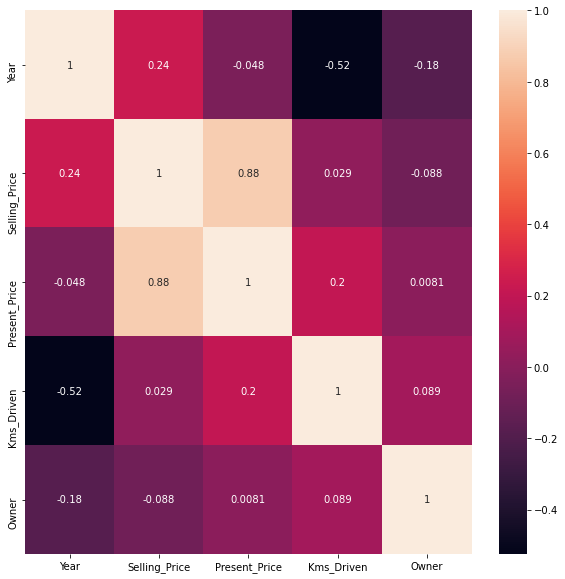

In [11]:
# See correlation between features using heatmap
plt.figure(figsize=(10,10))
sns.heatmap(car_df.corr(), annot=True)
plt.show()

#### **Inference**
Compare correlation between Selling_Price (target variable) with other features.

* Selling_Price, Year - Positively correlated which means when year increases, selling price also increases.
* Selling_Price, Present_Price - Positively correlated which means when present price increases, selling price also increases.
* Selling_Price, Kms_Driven - Doesn't have any significant coorelation.
* Selling_Price, Owner - Doesn't have any significant coorelation.

In [12]:
# Compare Average Selling_Price across 'Year'
pd.pivot_table(car_df, index='Selling_Price', values=['Year'])

,Year
Selling_Price,
0.10,2006.000000
0.12,2007.000000
0.15,2011.000000
0.16,2010.000000
0.17,2008.000000
...,...
20.75,2016.000000
23.00,2015.666667
23.50,2015.000000


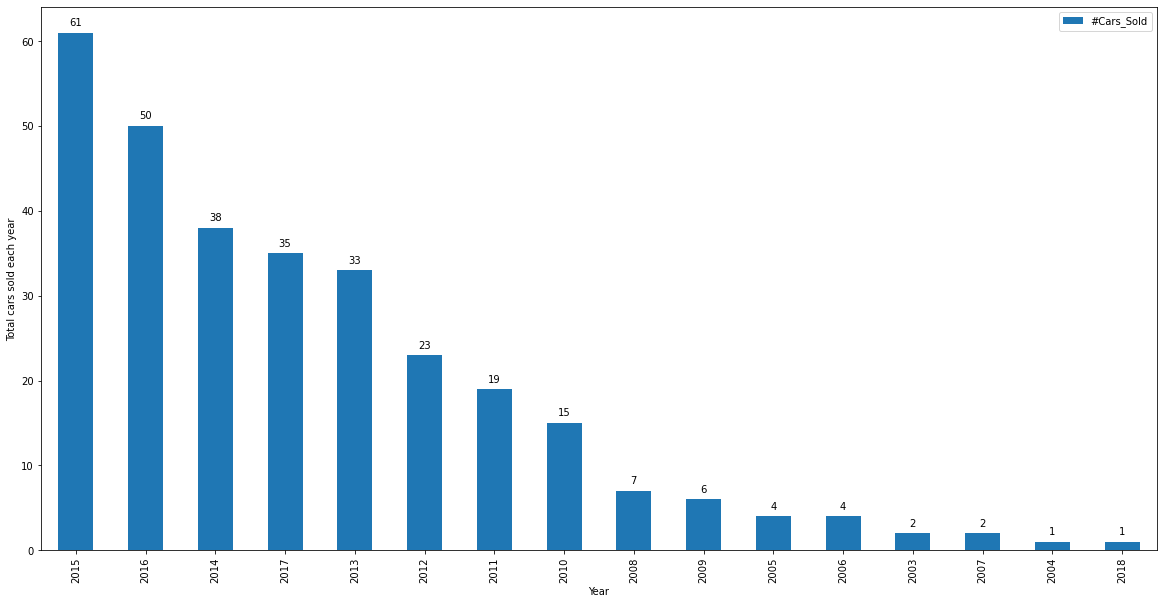

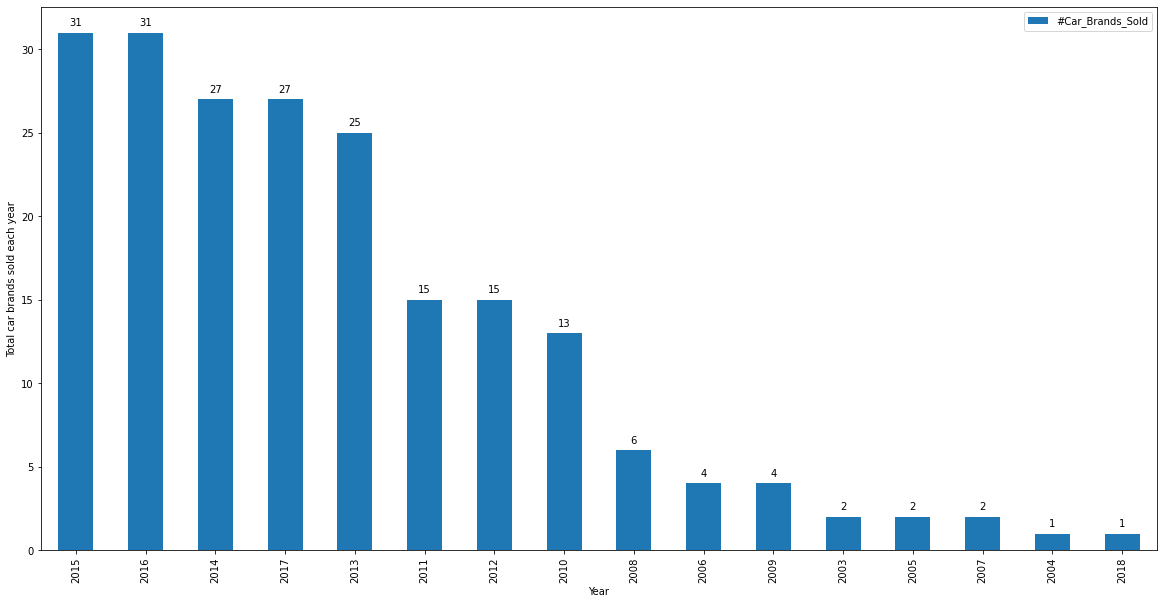

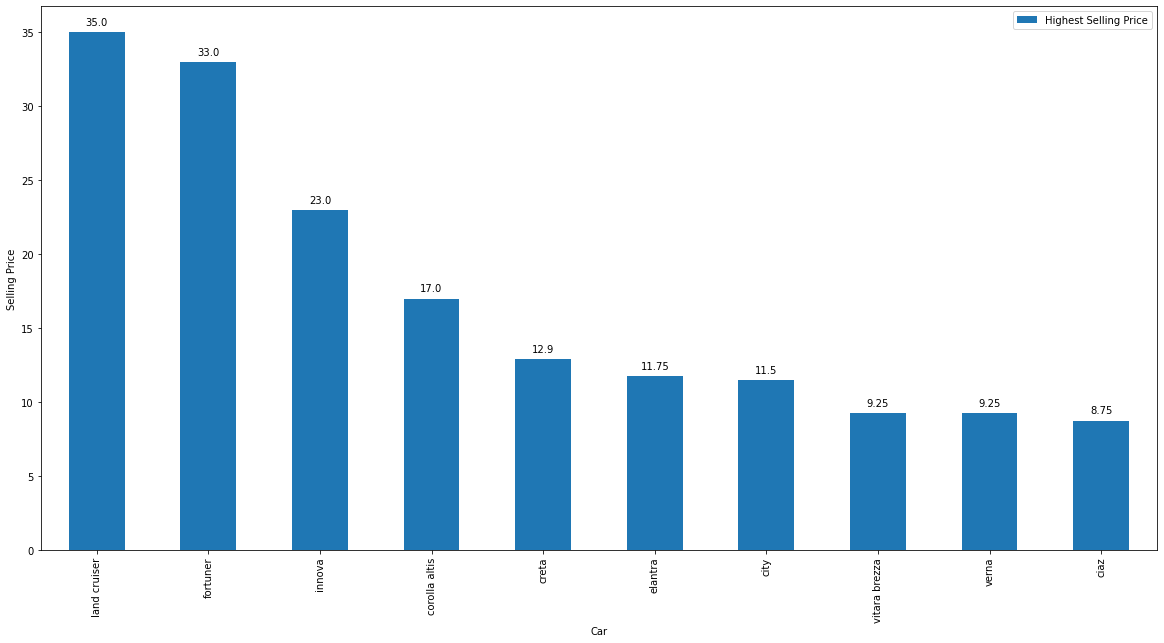

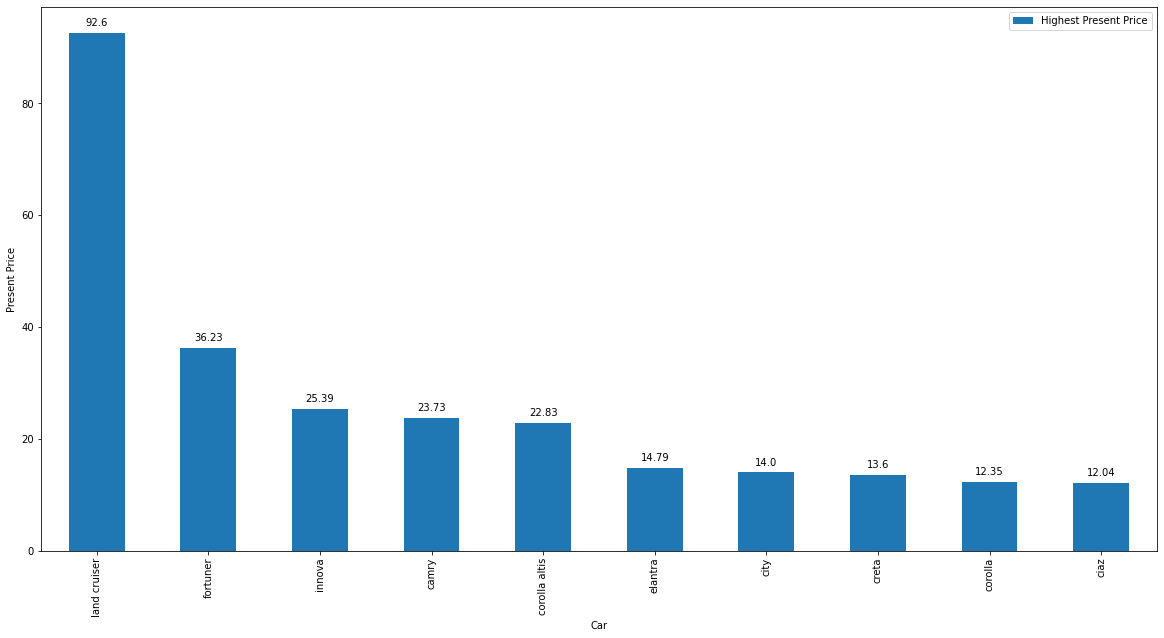

In [13]:
# For checking distribution of categorical columns - use value_counts()

# How many cars were sold each year?
grouped_df1 = car_df.groupby(['Year'])['Car_Name'].count().reset_index(name="#Cars_Sold").sort_values(by='#Cars_Sold', ascending=False)
ax = grouped_df1.plot(kind='bar', x='Year', y='#Cars_Sold', xlabel='Year', ylabel='Total cars sold each year', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
        
        
# How many different brands of cars were sold each year?
grouped_df2 = car_df.groupby(['Year'])['Car_Name'].nunique().reset_index(name="#Car_Brands_Sold").sort_values(by='#Car_Brands_Sold', ascending=False)
ax = grouped_df2.plot(kind='bar', x='Year', y='#Car_Brands_Sold', xlabel='Year', ylabel='Total car brands sold each year', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
       
    
# Which cars had highest selling price?
grouped_df3 = car_df.groupby(['Car_Name'])['Selling_Price'].max().reset_index(name="Highest Selling Price").sort_values(by='Highest Selling Price', ascending=False)[0:10]
ax = grouped_df3.plot(kind='bar', x='Car_Name', y='Highest Selling Price', xlabel='Car', ylabel='Selling Price', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
        
# Which cars had highest present price?
grouped_df4 = car_df.groupby(['Car_Name'])['Present_Price'].max().reset_index(name="Highest Present Price").sort_values(by='Highest Present Price', ascending=False)[0:10]
ax = grouped_df4.plot(kind='bar', x='Car_Name', y='Highest Present Price', xlabel='Car', ylabel='Present Price', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 

#### **Inference**
From the graphs, it's observed that:
* Top 5 years in which majority of cars were sold - 2015 (61 cars), 2016 (50 cars), 2014 (38 cars), 2017 (35 cars)
* Top 5 years in which majority of unique car brands were sold - 2015 (31 cars), 2016 (31 cars), 2014 (27 cars), 2017 (27 cars)
* Top 5 cars with the highest selling_price - land cruiser (35.0K), fortuner (33.0K), innova (23.0K), corolla altis (17.0K), creta (12.9K) etc.
* Top 5 cars with the highest present_price - land cruiser (92.6K), fortuner (36.23K), innova (25.39K), camry (23.73K), corolla altis (22.83K) etc.

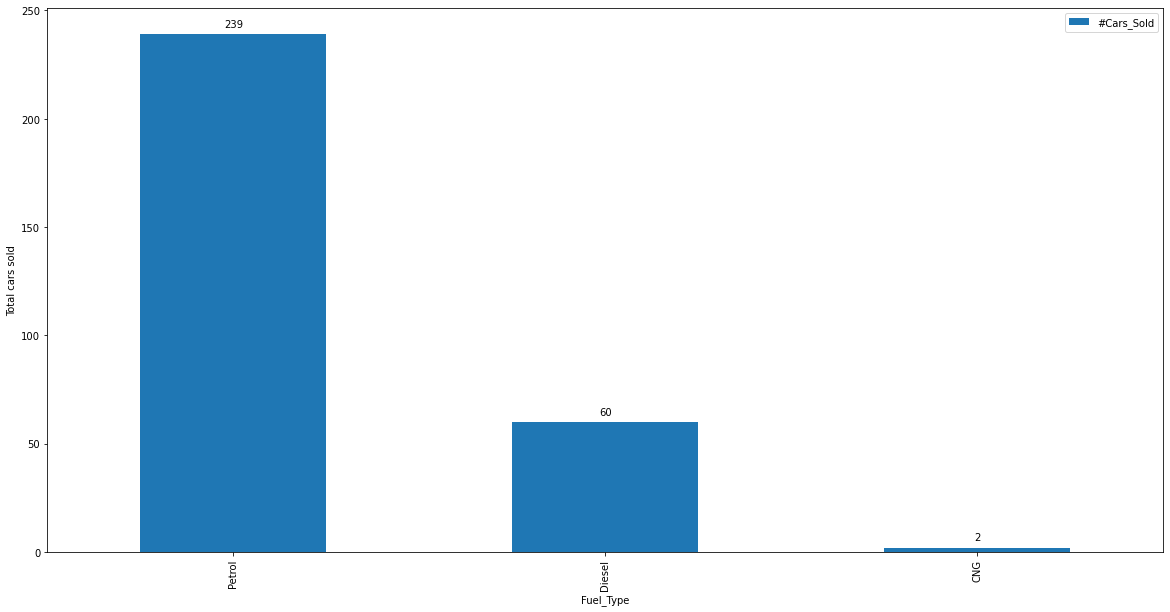

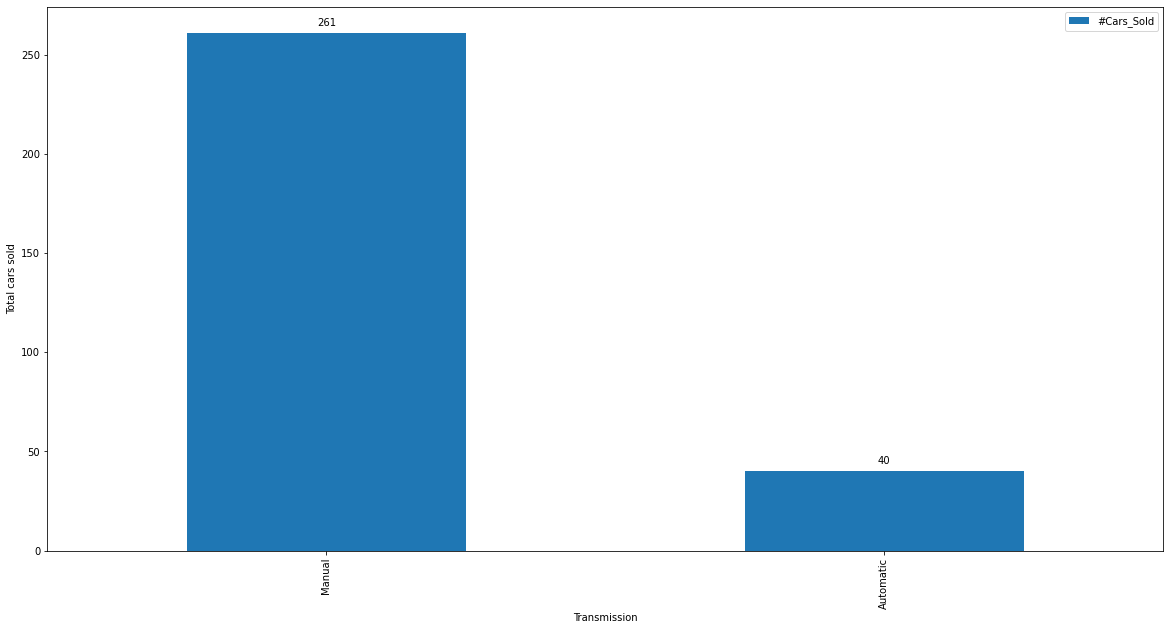

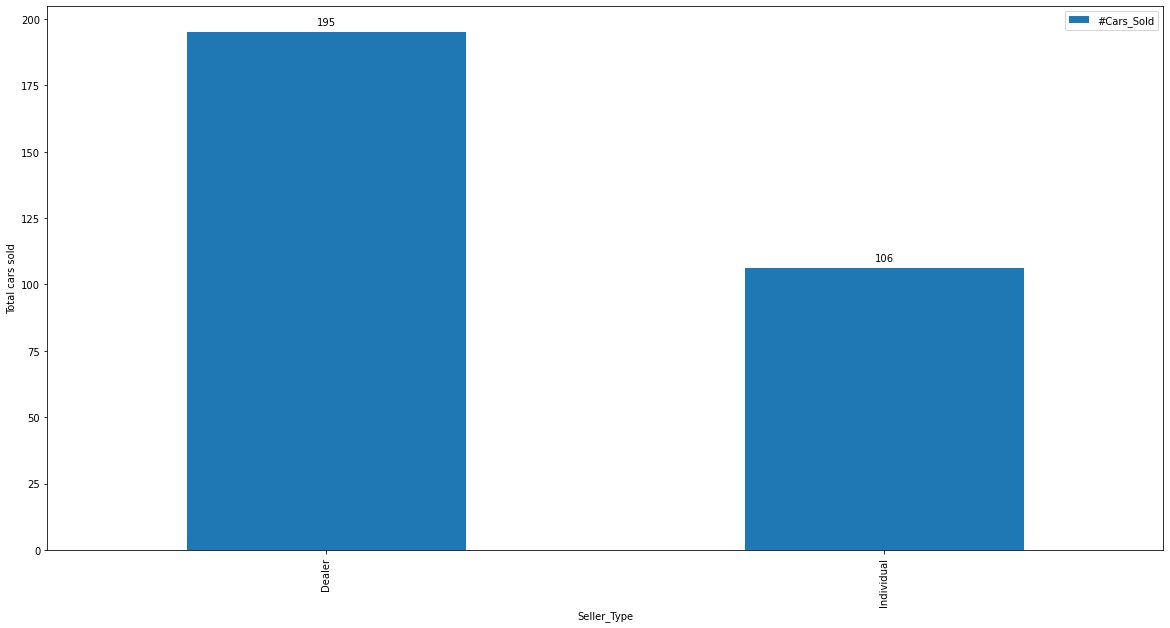

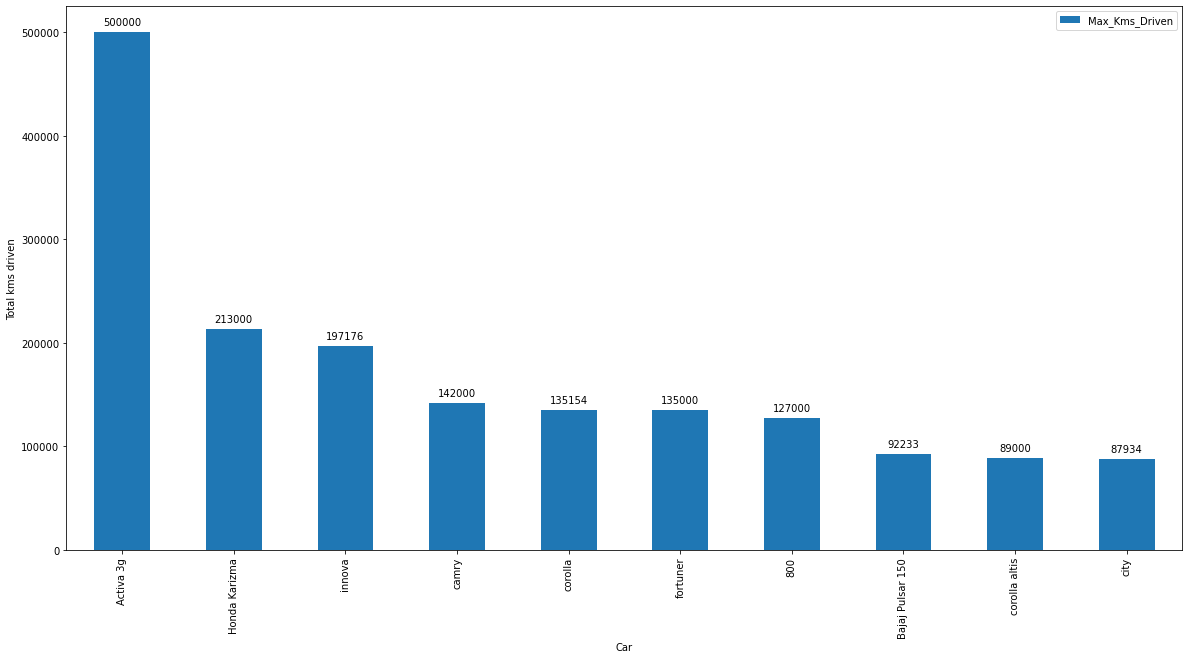

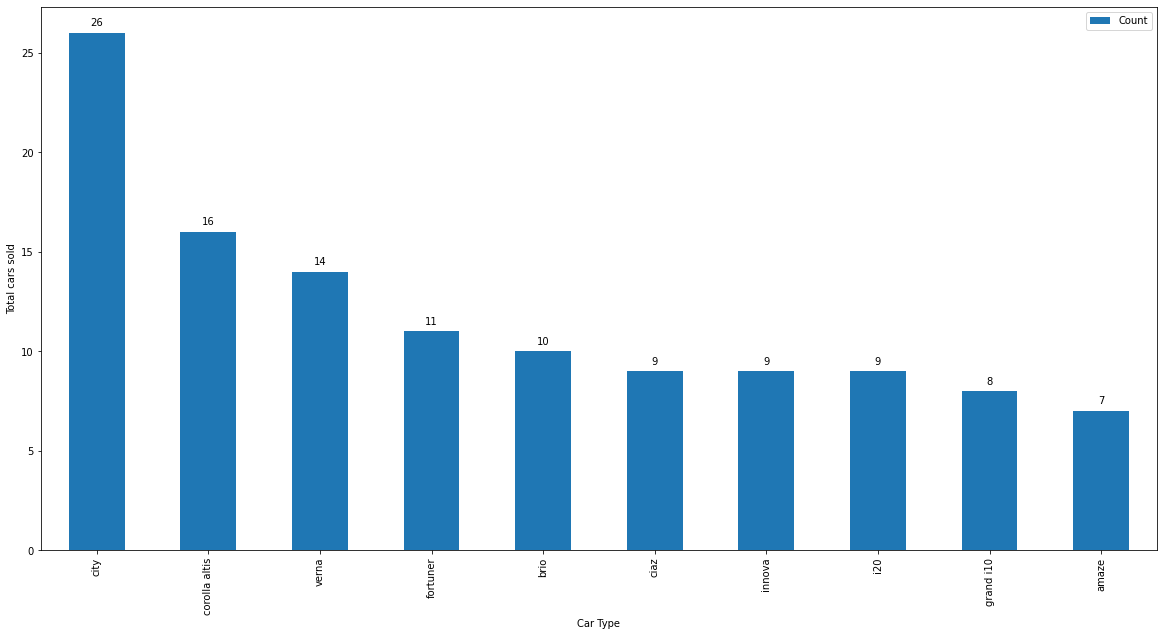

In [14]:
# How many cars of a specific fuel-type were sold?
grouped_df5 = car_df.groupby(['Fuel_Type'])['Car_Name'].count().reset_index(name="#Cars_Sold").sort_values(by='#Cars_Sold', ascending=False)[0:10]
ax = grouped_df5.plot(kind='bar', x='Fuel_Type', y='#Cars_Sold', xlabel='Fuel_Type', ylabel='Total cars sold', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
        

# How many cars of a specific transmission were sold?
grouped_df6 = car_df.groupby(['Transmission'])['Car_Name'].count().reset_index(name="#Cars_Sold").sort_values(by='#Cars_Sold', ascending=False)[0:10]
ax = grouped_df6.plot(kind='bar', x='Transmission', y='#Cars_Sold', xlabel='Transmission', ylabel='Total cars sold', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
        

# How many cars of a specific seller-type were sold?
grouped_df6 = car_df.groupby(['Seller_Type'])['Car_Name'].count().reset_index(name="#Cars_Sold").sort_values(by='#Cars_Sold', ascending=False)[0:10]
ax = grouped_df6.plot(kind='bar', x='Seller_Type', y='#Cars_Sold', xlabel='Seller_Type', ylabel='Total cars sold', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
        
# Car with highest KMS Driven?
grouped_df7 = car_df.groupby(['Car_Name'])['Kms_Driven'].max().rename('Max_Kms_Driven').reset_index().sort_values(by='Max_Kms_Driven', ascending=False)[0:10]
ax = grouped_df7.plot(kind='bar', x='Car_Name', y='Max_Kms_Driven', xlabel='Car', ylabel='Total kms driven', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 


# How many cars of a specific brand were sold?
grouped_df8 = car_df[['Car_Name']].value_counts().rename('Count').reset_index().sort_values(by='Count', ascending=False)[0:10]
ax = grouped_df8.plot(kind='bar', x='Car_Name', y='Count', xlabel='Car Type', ylabel='Total cars sold', figsize=(20,10))
plt.legend(loc='upper right')
for p in ax.patches:   
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 
   

#### **Inference**
From the graphs, it's observed that:
* Most no:of cars sold had fuel_type - petrol
* Most no:of cars sold had transmission - manual
* Most no:of cars sold had seller_type - dealer
* Majority of the cars sold were petrol cars with manual transmission which were sold through dealers 
* Top 5 cars with the highest kms_driven/most used cars - activa 3g, honda karizma, innova, camry, corolla
* Top 5 brands that sold the most cars - city, corolla altis, verna, fortuner, brio

In [15]:
# Selling price high for what type of cars - Fuel_Type, Transmission, Seller_Type?    
grouped_df9 = car_df.groupby(['Fuel_Type', 'Transmission', 'Seller_Type'])['Selling_Price'].max().rename('Max_SP').reset_index().sort_values(by='Max_SP', ascending=False)
grouped_df9

,Fuel_Type,Transmission,Seller_Type,Max_SP
3,Diesel,Manual,Dealer,35.00
1,Diesel,Automatic,Dealer,33.00
4,Petrol,Automatic,Dealer,19.75
6,Petrol,Manual,Dealer,17.00
2,Diesel,Automatic,Individual,16.00
7,Petrol,Manual,Individual,6.00
0,CNG,Manual,Dealer,3.25
5,Petrol,Automatic,Individual,2.50


In [16]:
# Selling price high for what type of cars - Fuel_Type, Transmission, Seller_Type, Kms_Driven?    
grouped_df10 = car_df.groupby(['Fuel_Type', 'Transmission', 'Seller_Type', 'Kms_Driven'])['Selling_Price'].max().rename('Max_SP').reset_index().sort_values(by='Max_SP', ascending=False)
grouped_df10

,Fuel_Type,Transmission,Seller_Type,Kms_Driven,Max_SP
49,Diesel,Manual,Dealer,78000,35.00
2,Diesel,Automatic,Dealer,6000,33.00
7,Diesel,Automatic,Dealer,47000,23.50
3,Diesel,Automatic,Dealer,15000,23.00
5,Diesel,Automatic,Dealer,40000,23.00
...,...,...,...,...,...
242,Petrol,Manual,Individual,49000,0.20
245,Petrol,Manual,Individual,55000,0.20
78,Petrol,Automatic,Individual,500000,0.17
244,Petrol,Manual,Individual,53000,0.12


In [17]:
# Type of car with highest KMS driven?   
grouped_df11 = car_df.groupby(['Selling_Price', 'Present_Price', 'Fuel_Type', 'Seller_Type', 'Transmission'])['Kms_Driven'].max().rename('Max_Kms_Driven').reset_index().sort_values(by='Max_Kms_Driven', ascending=False)
grouped_df11

,Selling_Price,Present_Price,Fuel_Type,Seller_Type,Transmission,Max_Kms_Driven
4,0.17,0.52,Petrol,Individual,Automatic,500000
19,0.31,1.05,Petrol,Individual,Manual,213000
140,3.49,13.46,Diesel,Dealer,Manual,197176
108,2.50,23.73,Petrol,Individual,Automatic,142000
95,1.50,12.35,Petrol,Dealer,Automatic,135154
...,...,...,...,...,...,...
70,0.90,0.95,Petrol,Individual,Manual,1300
94,1.45,1.60,Petrol,Individual,Manual,1200
36,0.45,0.55,Petrol,Individual,Manual,1000
34,0.45,0.54,Petrol,Individual,Automatic,500


#### **Inference**
From the results, it's observed that:
* Selling price is highest for diesel cars with manual/automatic transmission which were sold through dealers
* Kms driven is highest for petrol cars with manual/automatic transmission which were sold through individuals

### Data Preprocessing

In [18]:
# Preprocess Car_Name
car_df['Car_Name'] = car_df['Car_Name'].apply(lambda x: x.lower().strip())
car_df.Car_Name.unique()

array(['ritz', 'sx4', 'ciaz', 'wagon r', 'swift', 'vitara brezza',
       's cross', 'alto 800', 'ertiga', 'dzire', 'alto k10', 'ignis',
       '800', 'baleno', 'omni', 'fortuner', 'innova', 'corolla altis',
       'etios cross', 'etios g', 'etios liva', 'corolla', 'etios gd',
       'camry', 'land cruiser', 'royal enfield thunder 500',
       'um renegade mojave', 'ktm rc200', 'bajaj dominar 400',
       'royal enfield classic 350', 'ktm rc390', 'hyosung gt250r',
       'royal enfield thunder 350', 'ktm 390 duke', 'mahindra mojo xt300',
       'bajaj pulsar rs200', 'royal enfield bullet 350',
       'royal enfield classic 500', 'bajaj avenger 220',
       'bajaj avenger 150', 'honda cb hornet 160r', 'yamaha fz s v 2.0',
       'yamaha fz 16', 'tvs apache rtr 160', 'bajaj pulsar 150',
       'honda cbr 150', 'hero extreme', 'bajaj avenger 220 dtsi',
       'bajaj avenger 150 street', 'yamaha fz  v 2.0',
       'bajaj pulsar  ns 200', 'bajaj pulsar 220 f', 'tvs apache rtr 180',
       '

In [19]:
# Check for missing values
car_df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [20]:
# Check for NaN values
car_df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

<AxesSubplot:>

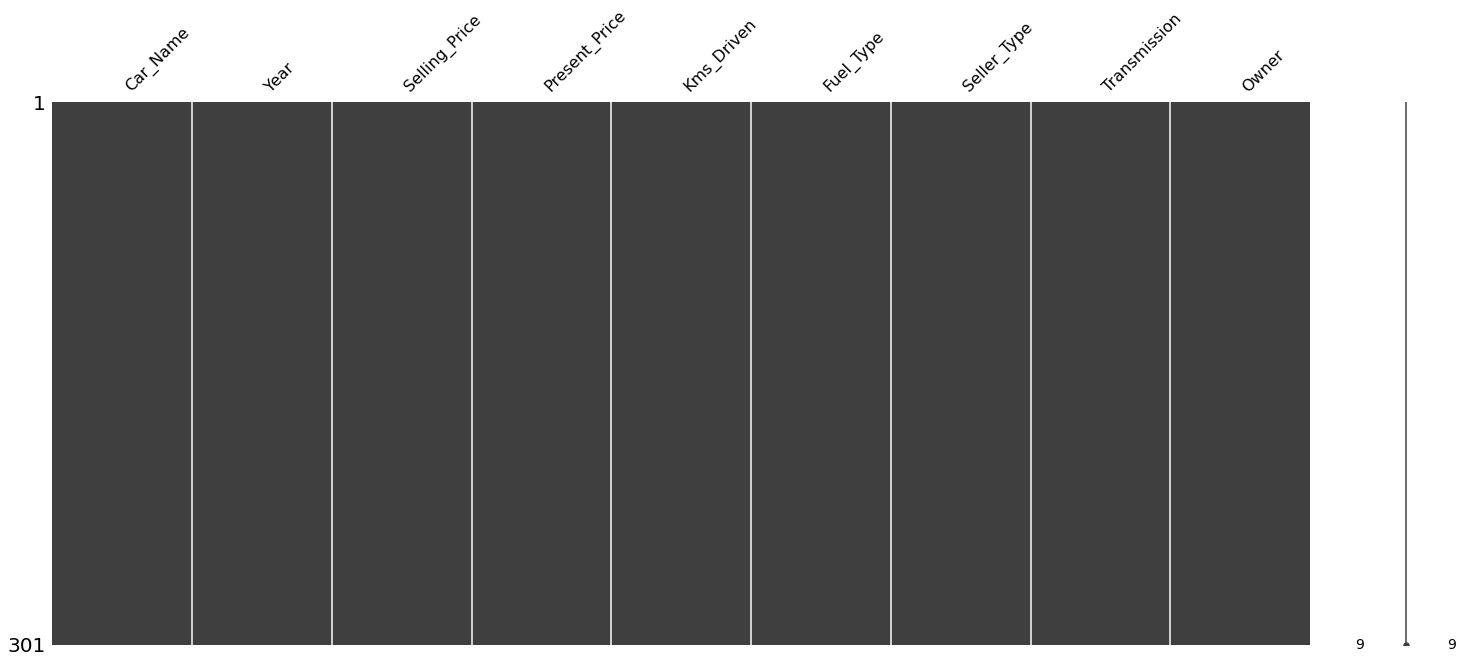

In [21]:
msno.matrix(car_df)

<AxesSubplot:>

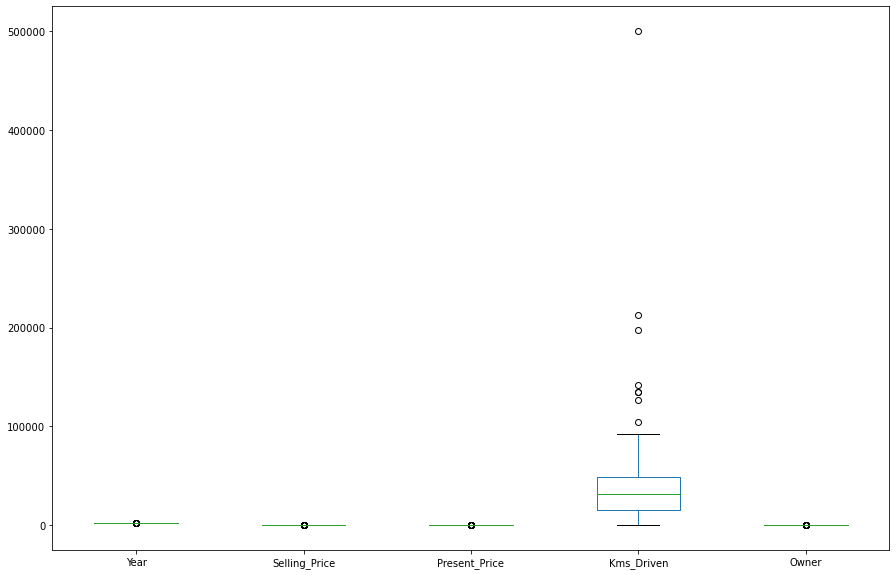

In [22]:
# Check for outliers using boxplot
car_df.plot(kind='box', figsize=(15,10))

In [23]:
# Identify and remove outliers with standard deviation

# Calculate summary statistics
data_mean, data_std = mean(car_df), std(car_df)

# Identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers = car_df[((car_df < lower)|(car_df > upper)).any(axis=1)]
print('Identified outliers: ', outliers.shape)
# Remove outliers
final_car_df = car_df[((car_df >= lower)|(car_df <= upper)).any(axis=1)]
print('Non-outlier observations: ', final_car_df.shape)

Identified outliers:  (39, 9)
Non-outlier observations:  (301, 9)


In [24]:
# Encode categorical values - Fuel_Type, Seller_Type, Transmission, Owner
final_car_df = pd.get_dummies(final_car_df, columns = ['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)
final_car_df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,ritz,2014,3.35,5.59,27000,0,0,1,0,1
1,sx4,2013,4.75,9.54,43000,0,1,0,0,1
2,ciaz,2017,7.25,9.85,6900,0,0,1,0,1
3,wagon r,2011,2.85,4.15,5200,0,0,1,0,1
4,swift,2014,4.60,6.87,42450,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,0,1,0,0,1
297,brio,2015,4.00,5.90,60000,0,0,1,0,1
298,city,2009,3.35,11.00,87934,0,0,1,0,1
299,city,2017,11.50,12.50,9000,0,1,0,0,1


#### **Inference**

* The dataset didn't contain any missing/NaN values
* Shape of dataset before outlier removal using Standard Deviation method - (301, 9)
* Shape of dataset after outlier removal using Standard Deviation method - (301, 9)
* Standard Deviation method was chosen for outlier removal because it resulted in less data loss than IQR method
* Encode categorical values into numeric values for model training

### Feature Engineering

In [25]:
# Derive age of each car
current_year = 2021
final_car_df['Car_Age'] = final_car_df['Year'].apply(lambda x: current_year - x)
final_car_df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Car_Age
0,ritz,2014,3.35,5.59,27000,0,0,1,0,1,7
1,sx4,2013,4.75,9.54,43000,0,1,0,0,1,8
2,ciaz,2017,7.25,9.85,6900,0,0,1,0,1,4
3,wagon r,2011,2.85,4.15,5200,0,0,1,0,1,10
4,swift,2014,4.60,6.87,42450,0,1,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,0,1,0,0,1,5
297,brio,2015,4.00,5.90,60000,0,0,1,0,1,6
298,city,2009,3.35,11.00,87934,0,0,1,0,1,12
299,city,2017,11.50,12.50,9000,0,1,0,0,1,4


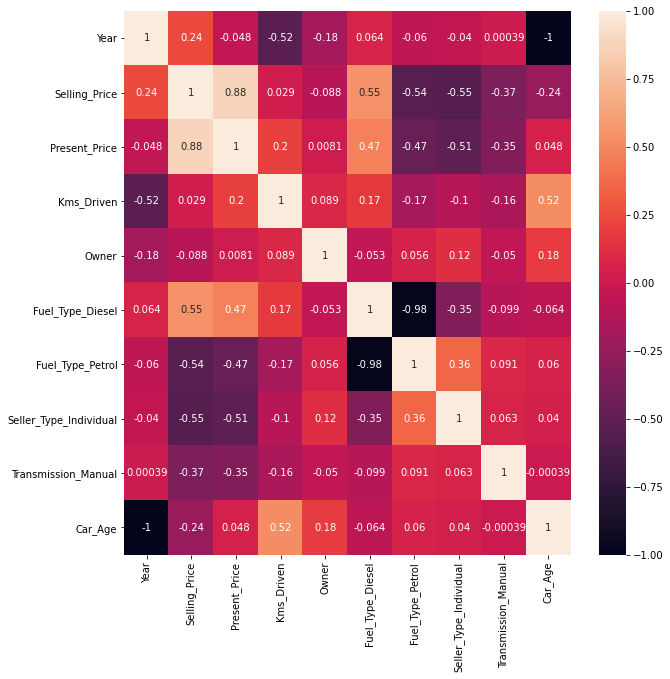

In [26]:
# See correlation between features using heatmap
plt.figure(figsize=(10,10))
sns.heatmap(final_car_df.corr(), annot=True)
plt.show()

### Feature Selection

In [27]:
# Select the features needed for model building
X = final_car_df[final_car_df.columns[~final_car_df.columns.isin(['Car_Name', 'Year', 'Selling_Price'])]]
y = final_car_df['Selling_Price']

In [28]:
X.columns

Index(['Present_Price', 'Kms_Driven', 'Owner', 'Fuel_Type_Diesel',
       'Fuel_Type_Petrol', 'Seller_Type_Individual', 'Transmission_Manual',
       'Car_Age'],
      dtype='object')

In [29]:
# Select features in order of their importance
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)

[0.36470119 0.04827562 0.00037896 0.22936574 0.01562125 0.12192379
 0.15002763 0.06970582]


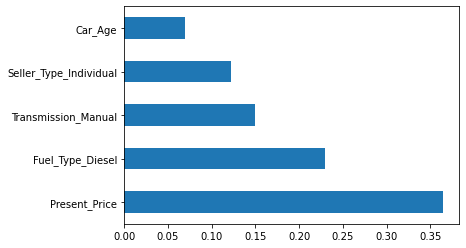

In [30]:
# Plot graph of feature importances for better visualization
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(5).plot(kind='barh')
plt.show()

#### **Inference**

* All columns except Car_Name, Year, Selling_Price are chosen as the features for model training
* The column Selling_Price is the target variable
* Top 5 features in increasing order of their importance - Car_Age, Seller_Type_Individual, Transmission_Manual, Fule_Type_Diesel, Present_Price

### Model Training

In [31]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
print(X_train.shape, y_train.shape)

# Present_Price, Kms_Driven showed right-skewed distribution, hence they should be normalized
# Since RandomForestRegressor is used, there's no need to scale the values
# sc = StandardScaler()
# X_train[['Present_Price','Kms_Driven']] = sc.fit_transform(X_train[['Present_Price','Kms_Driven']])
# X_test[['Present_Price','Kms_Driven']] = sc.transform(X_test[['Present_Price','Kms_Driven']])

(90, 8) (90,)


In [32]:
# Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [33]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_regressor = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation
# search across 100 different combinations
rf_model = RandomizedSearchCV(estimator = rf_regressor,
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2,
                               random_state=42, n_jobs = 1)

rf_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.2s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   2.6s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.7s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [34]:
rf_model.best_params_, rf_model.best_score_

({'n_estimators': 1000,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 25},
 -5.281403794551449)

In [35]:
y_pred = rf_model.predict(X_test)
y_pred

array([ 2.52682 ,  8.95135 ,  5.7278  ,  0.45867 ,  6.43375 ,  6.28576 ,
        0.9498  ,  0.74612 ,  0.54091 ,  6.161955, 12.01847 ,  0.81494 ,
        7.22243 ,  3.44166 ,  5.34103 ,  2.80488 ,  1.07409 ,  9.54103 ,
        0.67678 ,  1.37797 ,  0.59982 ,  8.67621 ,  5.50894 ,  3.08905 ,
        0.56533 ,  3.67098 ,  4.528   ,  3.25049 ,  1.14265 ,  1.05431 ,
        0.54079 ,  9.826445,  0.5042  ,  2.72524 ,  7.80993 ,  4.303905,
        5.83171 ,  5.263   ,  2.86758 ,  5.64835 ,  4.32197 ,  5.61897 ,
        4.9533  ,  0.625595,  6.31528 ,  0.48393 ,  6.98755 ,  5.54168 ,
        3.22816 ,  4.94912 ,  5.6736  ,  1.37761 , 19.149845, 17.23286 ,
        7.033075,  7.86727 ,  5.03989 ,  8.63922 ,  2.79601 ,  6.94474 ,
        0.33424 ,  0.43267 ,  0.85509 ,  0.33883 ,  4.467505,  1.15107 ,
       18.108055, 15.492415,  5.98695 ,  0.72285 ,  4.94062 ,  4.41594 ,
        5.93971 ,  4.584225,  3.08361 ,  0.927735,  0.86568 ,  8.453   ,
        0.487885,  9.02198 ,  4.91855 ,  3.6485  , 

### Model Evaluation

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

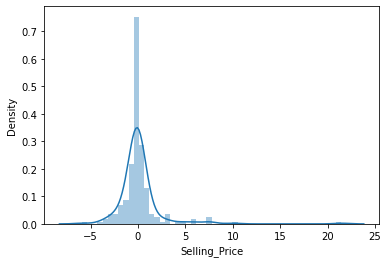

In [36]:
sns.distplot(y_test-y_pred)

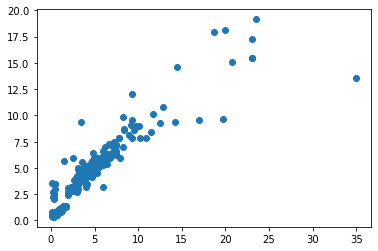

In [37]:
plt.scatter(y_test, y_pred)

In [38]:
# Display regression metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1.0392061848341252
MSE: 5.239206210126707
RMSE: 2.2889312375269615


#### **Inference**

From the graphs, it's observed that:
* Distplot gives a normal distribution between y_test and y_pred, because the difference between them is negligible 
* Scatterplot shows data points lying linearly

Hence the above points indicates that the model is showcasing good performance

In [39]:
# Save the model
# Open a file, where you want to store the data
rf_regressor_file = open(data_path + 'random_forest_regression_model.pkl', 'wb')

# Dump information to that file
pickle.dump(rf_model, rf_regressor_file)